# **Setting Up and Using the AniList API**

### **Tip 1**: Use a virtual environment to keep your dependencies isolated.  
### **Tip 2**: Don’t worry about tokens expiring—they last a long time.

---

## **Step 1: Register Your Application on AniList**

1. **Go to AniList Developer Settings**:  
   - [AniList Developer Settings](https://anilist.co/settings/developer).
   - [Heres the docs aswell](https://docs.anilist.co/guide/graphql/).

2. **Create a New Application**:
   - If you don’t have an AniList account, create one.
   - **Application Name**: Choose a memorable name.
   - **Redirect URL**: Use a dummy URL like `https://example.com/callback`.  
     *(No web development is needed; this is just for OAuth).*

3. **Save the Application**:
   - You’ll receive:
     - **Client ID**
     - **Client Secret**
   - **Important**: Save these securely.
---

## **Step 2: Obtain an Authorization Code**

### **Why Use Authorization Code Grant?**
We’ll hide sensitive keys in a `.env` file and add it to `.gitignore` for security.

### **Construct the Authorization URL**  
Replace placeholders with your actual values:
https://anilist.co/api/v2/oauth/authorize?client_id=YOUR_CLIENT_ID&response_type=code&redirect_uri=YOUR_REDIRECT_URI


### 1.**Open the URL in a Browser**

- Log in to AniList.
- Grant permissions to your app.
- You’ll be redirected to your specified redirect URL, which includes the AUTH_CODE as a query parameter (e.g., https://example.com/callback?code=AUTH_CODE).


#### 2. **Copy the `AUTH_CODE` from the Redirect URL and save it to the `.env` file**



## **Step 3: Exchange Authorization Code for Access Token**

1. **Create a `.env` File**:  
   Store your credentials securely in the following format:

   CLIENT_ID="{INSERT}"

   CLIENT_SECRET="{INSERT}"

   REDIRECT_URI="{INSERT}"
   
   AUTH_CODE="{INSERT}"

2. **Run the First Code Cell**:

This makes a POST request to AniList's `token_url` and retrieves the `ACCESS_TOKEN`


In [28]:
import requests
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

# Access the environment variables
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')
REDIRECT_URI = os.getenv('REDIRECT_URI')
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')
AUTH_CODE = os.getenv('AUTH_CODE')

# Token request payload
token_url = 'https://anilist.co/api/v2/oauth/token' # public endpoint for Anilist 
payload = {
    'grant_type': 'authorization_code',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'redirect_uri': REDIRECT_URI,
    'code': AUTH_CODE
}

# Send POST request to exchange code for access token
response = requests.post(token_url, data=payload)
token_data = response.json()

# Print the access token

# Uncomment this, doesn't work after a couple of tries to mark down result
#print("Access Token:", token_data['access_token'])

3. **Add the ACCESS_TOKEN to Your .env File:**
    
    ACCESS_TOKEN="{INSERT}"

4. **Testing json data**

    Now run the cell below to test if you can fetch the anime json data


In [45]:
import requests

# Your access token
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')

# Authorization headers
headers = {
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

# GraphQL query to fetch anime details
query = '''
query ($id: Int) {
  Media(id: $id, type: ANIME) {
    id
    title {
      romaji
      english
      native
    }
    format
    episodes
    status
    averageScore
    popularity
    genres
  }
}
'''

# Variables for the query
variables = {
    'id': 1  # Example ID for "Cowboy Bebop"
}

# Make the request
url = 'https://graphql.anilist.co'
response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)

# Print the response
print(response.json())


{'data': {'Media': {'id': 1, 'title': {'romaji': 'Cowboy Bebop', 'english': 'Cowboy Bebop', 'native': 'カウボーイビバップ'}, 'format': 'TV', 'episodes': 26, 'status': 'FINISHED', 'averageScore': 86, 'popularity': 372155, 'genres': ['Action', 'Adventure', 'Drama', 'Sci-Fi']}}}


The result for the last response should be 

{'data': {'Media': {'id': 1, 'title': {'romaji': 'Cowboy Bebop', 'english': 'Cowboy Bebop', 'native': 'カウボーイビバップ'}, 'format': 'TV', 'episodes': 26, 'status': 'FINISHED', 'averageScore': 86, 'popularity': 372155, 'genres': ['Action', 'Adventure', 'Drama', 'Sci-Fi']}}}

If that's the case then we have finished up setting up the API for Anilist.

Time for MyAnimeList (MAL)


## **Setting Up and Using the MAL API**

1. Set up for a MAL Account [Sign Up](https://myanimelist.net/)

These links will be useful for you
- [Steps to follow](https://myanimelist.net/forum/?topicid=1973141)
- [Has helpful links](https://myanimelist.net/clubs.php?cid=13727)


2. Now go to the [API Panel](https://myanimelist.net/apiconfig) so we can request a client_id so we can work with this. Also remember to hide it in the .env file like before. Follow the same safety proceeders like with the last API

When you finish making your account and clicking on the API Panel fill it out very similar to how I have it. 
We're using the same dummy values and links as before since this isn't a web application.

A photo is displayed below for how I set it up.

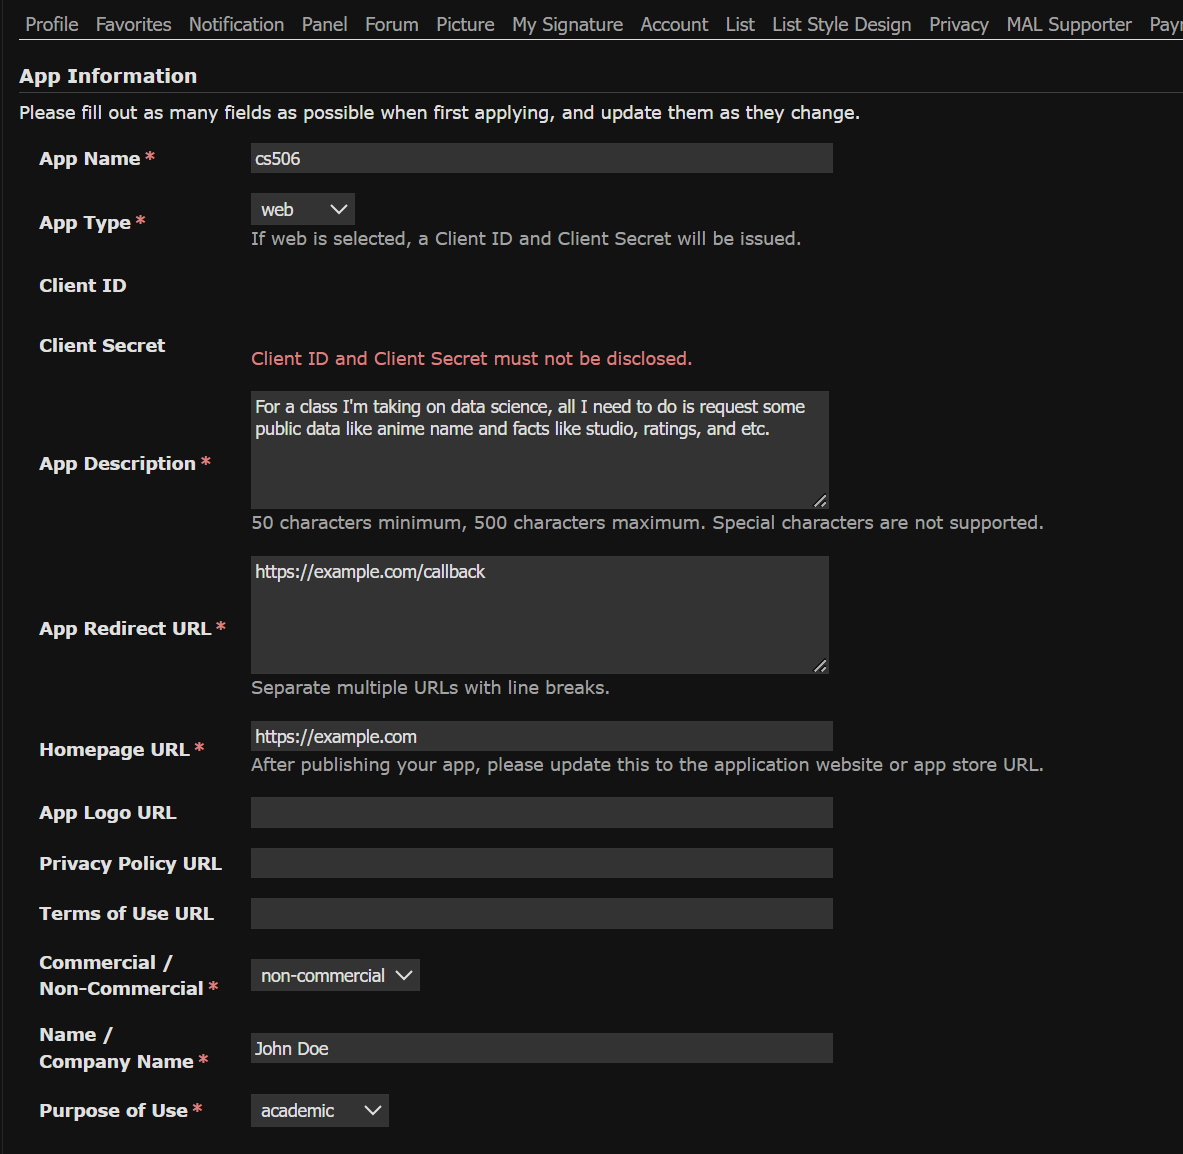

In [38]:
from IPython.display import Image, display
display(Image(filename='reference_photos/MAL_Panel_API_Photo.PNG', width=600))

Once your done go back to the "Clients Accessing the MAL API" section and
click edit once you do that you'll go back into the API you just made, but your CLIENT_ID and CLIENT_SECRET will be present. 

Now put your MAL values in your .env folder

Your finalized .env folder should look something like this

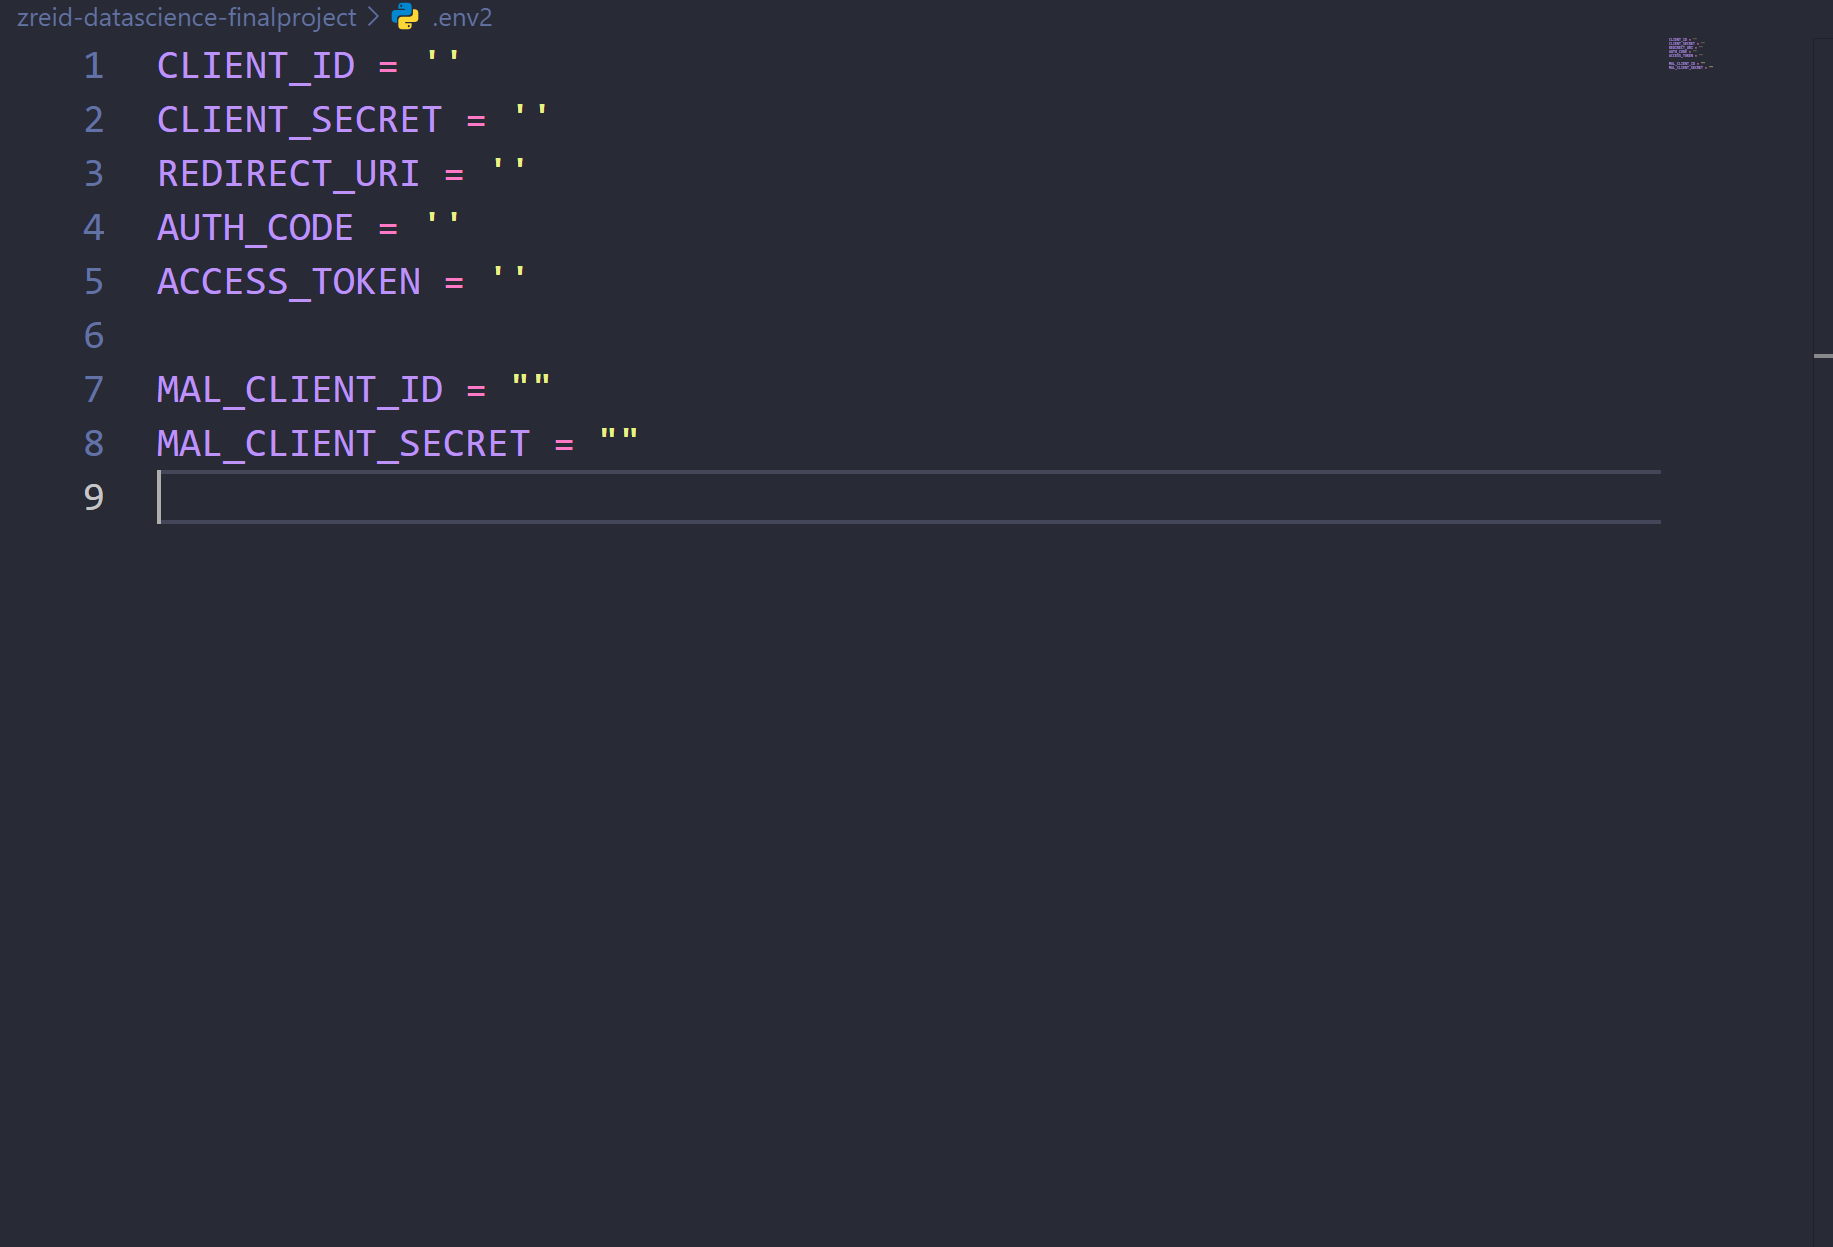

In [41]:
display(Image(filename='reference_photos/Finalized env file.PNG', width=700))
# just replace the quotes with the respective values

Now run the respective blocks of code below you should get the same Cowboy Bebop show result as before
but instead were using a different API

In [ ]:
import requests

# Your MAL_CLIENT_ID
MAL_CLIENT_ID = os.getenv('MAL_CLIENT_ID')

# Endpoint to fetch anime data
anime_id = 1  # Example: ID for "Cowboy Bebop"
url = f"https://api.myanimelist.net/v2/anime/{anime_id}"

# Headers with Client ID
headers = {
    "X-MAL-CLIENT-ID": MAL_CLIENT_ID
}

# Make the GET request
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    print("Anime Data:", data)
else:
    print(f"Error {response.status_code}: {response.text}")

Anime Data: {'id': 1, 'title': 'Cowboy Bebop', 'main_picture': {'medium': 'https://cdn.myanimelist.net/images/anime/4/19644.jpg', 'large': 'https://cdn.myanimelist.net/images/anime/4/19644l.jpg'}}


In [43]:
# Specify fields to include in the response
params = {
    "fields": "id,title,synopsis,mean,genres,studios"
}

# Make the GET request with parameters
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()
    print("Anime Data:", data)
else:
    print(f"Error {response.status_code}: {response.text}")


Anime Data: {'id': 1, 'title': 'Cowboy Bebop', 'main_picture': {'medium': 'https://cdn.myanimelist.net/images/anime/4/19644.jpg', 'large': 'https://cdn.myanimelist.net/images/anime/4/19644l.jpg'}, 'synopsis': "Crime is timeless. By the year 2071, humanity has expanded across the galaxy, filling the surface of other planets with settlements like those on Earth. These new societies are plagued by murder, drug use, and theft, and intergalactic outlaws are hunted by a growing number of tough bounty hunters.\n\nSpike Spiegel and Jet Black pursue criminals throughout space to make a humble living. Beneath his goofy and aloof demeanor, Spike is haunted by the weight of his violent past. Meanwhile, Jet manages his own troubled memories while taking care of Spike and the Bebop, their ship. The duo is joined by the beautiful con artist Faye Valentine, odd child Edward Wong Hau Pepelu Tivrusky IV, and Ein, a bioengineered Welsh Corgi.\n\nWhile developing bonds and working to catch a colorful cast

### Finished Setting up

Congraduations you finished setting up everything from this point on, were gonna go a little bit faster and worry more about solving our main problem with this data.

Like I said in the beginning were going to be training our model with the following data from the APIs so we can actually figure out its TRUE RATING based on as many factors as possible. 

Ex. Studio, num of episodes, Season, Popularity, favorites, etc. 
Then at the end we should be able to input a valid anime that exist and figure out its true score and compared it to its respective anilist and MAL counterparts

Just to repeat again from this point on explinations will mostly be in code format

In [44]:
# Next couple of steps 
# 1. Filter API request so we only get factors we want like (studio, episodes, etc.)
# 2. Get 1,000 random animes from each API and convert to .json 
# 3. convert that same .json into csv files 
# 4. train data to get result. 

In [ ]:
# Anilist Fetching animes and making CSV file 
import requests
import random
import time
import pandas as pd
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Your AniList access token
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')

# Authorization headers
headers = {
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

# GraphQL query to fetch anime details (only TV format)
query = '''
query ($page: Int, $perPage: Int) {
  Page(page: $page, perPage: $perPage) {
    media(type: ANIME, format: TV) {
      id
      title {
        romaji
        english
      }
      episodes
      status
      averageScore
      popularity
      genres
      studios {
        edges {
          node {
            name
          }
        }
      }
      source
      season
      startDate {
        year
        month
        day
      }
      endDate {
        year
        month
        day
      }
    }
  }
}
'''

# Function to fetch anime details
def fetch_anime_details(pages_to_fetch=10, animes_per_page=50):
    anime_list = []

    for page in range(1, pages_to_fetch + 1):
        # Variables for the query
        variables = {
            'page': page,
            'perPage': animes_per_page
        }
        
        # Make the request
        url = 'https://graphql.anilist.co'
        response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)

        if response.status_code == 200:
            data = response.json()
            anime_list.extend(data['data']['Page']['media'])
        else:
            print(f"Error fetching page {page}: {response.status_code}, {response.text}")
            break

        # Delay to respect API limits
        time.sleep(0.5)

    return anime_list

# Fetch anime details
# change later to fetch 500
anime_data = fetch_anime_details(pages_to_fetch=10, animes_per_page=5)

# Process the data into a DataFrame
processed_anime_data = []

for anime in anime_data:
    studios = ", ".join([studio['node']['name'] for studio in anime['studios']['edges']])
    start_date = f"{anime['startDate']['year']}-{anime['startDate']['month']}-{anime['startDate']['day']}" if anime['startDate'] else None
    end_date = f"{anime['endDate']['year']}-{anime['endDate']['month']}-{anime['endDate']['day']}" if anime['endDate'] else None
    processed_anime_data.append({
        'id': anime['id'],
        'title_romaji': anime['title']['romaji'],
        'title_english': anime['title']['english'],
        'episodes': anime['episodes'],
        'status': anime['status'],
        'average_score': anime['averageScore'],
        'popularity': anime['popularity'],
        'genres': ", ".join(anime['genres']),
        'studios': studios,
        'source': anime['source'],
        'season': anime['season'],
        'start_date': start_date,
    })

df = pd.DataFrame(processed_anime_data)

# Save to CSV
df.to_csv('data/raw_anilist.csv', index=False)

print("Fetched 500 TV anime and saved to 'data/raw_anilist.csv'")

Fetched 500 TV anime and saved to 'data/raw_anilist.csv'


In [ ]:
import requests
import time
import pandas as pd
from dotenv import load_dotenv
import os
import random

# Load environment variables from .env
load_dotenv()
MAL_CLIENT_ID = os.getenv('MAL_CLIENT_ID')

# Function to fetch a single anime's details
def fetch_anime(anime_id):
    url = f"https://api.myanimelist.net/v2/anime/{anime_id}"
    headers = {"X-MAL-CLIENT-ID": MAL_CLIENT_ID}
    params = {
        "fields": "id,title,episodes,studios,start_date,end_date,genres,mean,source,status"
    }
    
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching anime ID {anime_id}: {response.status_code}, {response.text}")
        return None

# Fetch details for multiple random anime
def fetch_random_anime(num_anime=500, id_range=(1, 20000)):
    anime_list = []
    fetched_ids = set()

    while len(anime_list) < num_anime:
        anime_id = random.randint(*id_range)
        if anime_id in fetched_ids:
            continue  # Avoid fetching the same ID multiple times
        fetched_ids.add(anime_id)

        print(f"Fetching anime ID: {anime_id}")
        anime_data = fetch_anime(anime_id)
        if anime_data:
            anime_list.append({
                "id": anime_data.get("id"),
                "title": anime_data.get("title"),
                "episodes": anime_data.get("episodes"),
                "status": anime_data.get("status"),
                "average_score": anime_data.get("mean"),  # MAL uses "mean" for average score
                "popularity": None,  # MAL doesn't provide popularity directly
                "genres": ", ".join([genre["name"] for genre in anime_data.get("genres", [])]),
                "studios": ", ".join([studio["name"] for studio in anime_data.get("studios", [])]),
                "source": anime_data.get("source"),
                "start_date": anime_data.get("start_date"),
                "end_date": anime_data.get("end_date")
            })
        time.sleep(1)  # Delay to respect API rate limits

    return anime_list

# Fetch 500 anime details
# anime_data = fetch_random_anime(num_anime=20)
# anime_data = fetch_random_anime(num_anime=500)

# Convert to DataFrame
df = pd.DataFrame(anime_data)

# Save to CSV
df.to_csv('data/raw_mal.csv', index=False)

print("Fetched 500 anime and saved to 'data/raw_mal.csv'")


Fetching anime ID: 9073
Error fetching anime ID 9073: 404, {"message":"","error":"not_found"}
Fetching anime ID: 11743
Fetching anime ID: 3521
Error fetching anime ID 3521: 404, {"message":"","error":"not_found"}
Fetching anime ID: 9699
Error fetching anime ID 9699: 404, {"message":"","error":"not_found"}
Fetching anime ID: 874
Fetching anime ID: 8032
Error fetching anime ID 8032: 404, {"message":"","error":"not_found"}
Fetching anime ID: 13157
Error fetching anime ID 13157: 404, {"message":"","error":"not_found"}
Fetching anime ID: 11145
Error fetching anime ID 11145: 404, {"message":"","error":"not_found"}
Fetching anime ID: 4634
Error fetching anime ID 4634: 404, {"message":"","error":"not_found"}
Fetching anime ID: 10381
Error fetching anime ID 10381: 404, {"message":"","error":"not_found"}
Fetching anime ID: 13653
Error fetching anime ID 13653: 404, {"message":"","error":"not_found"}
Fetching anime ID: 16333
Error fetching anime ID 16333: 404, {"message":"","error":"not_found"}
Fe